LLEPE: Liquid-Liquid Equilibrium Parameter Estimator

Copyright © 2020, UChicago Argonne, LLC. All rights reserved.

Released under the modified BSD license. See LICENSE for more details.

This script performs the basic fit method and shows the parity plots for each of the species and requires that the elementz.xml file in the data folder has been copied into Cantera's data folder. 

# Fitting linear parameters to single component data

In [45]:
from llepe import LLEPE, lmse_perturbed_obj
import numpy as np
import itertools
import pandas as pd
import matplotlib
from scipy.optimize import curve_fit
import matplotlib
import matplotlib.pyplot as plt

font = {'family': 'sans serif',
        'size': 24}
matplotlib.rc('font', **font)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rcParams['lines.linewidth'] = 4
matplotlib.rcParams['lines.markersize'] = 10

In [30]:

def linear(x, a, b):
    return a * x + b


lp_dict = {'species': [],
           'slope': [],
           'intercept': []}
species_list = 'Nd,Pr,Ce,La,Dy,Sm,Y'.split(',')

n_guesses = 11
complex_guesses = -4e6 * np.logspace(-1, 1, n_guesses)
extractant_guesses = -1e6 * np.logspace(-1, 1, n_guesses)
x_guesses = list(itertools.product(*[complex_guesses, extractant_guesses]))
guess_ext_h0 = 0
for species in species_list:
    print(species)
    lower_species = species.lower()

    labeled_data = pd.read_csv("../../data/csvs/labeled_zeroes_removed_{0}.csv".format(lower_species))
    exp_data = labeled_data.drop(labeled_data.columns[0], axis=1)
    xml_file = '../../data/xmls/PC88A_HCL_{0}.xml'.format(species)
    opt_values = {
        'optimizer': [],
        'species': [],
        'parameter': [],
        'value': [],
        'obj_value': [],
        'guess': []}
    new_x_guesses = []

    for x_guess in x_guesses:
        info_dict = {'{0}(H(A)2)3(org)_h0'.format(species): {'upper_element_name': 'species',
                                       'upper_attrib_name': 'name',
                                       'upper_attrib_value': '{0}(H(A)2)3(org)'.format(species),
                                       'lower_element_name': 'h0',
                                       'lower_attrib_name': None,
                                       'lower_attrib_value': None,
                                       'input_format': '{0}',
                                       'input_value': x_guess[0]},
                     '(HA)2(org)_h0': {'upper_element_name': 'species',
                                       'upper_attrib_name': 'name',
                                       'upper_attrib_value': '(HA)2(org)',
                                       'lower_element_name': 'h0',
                                       'lower_attrib_name': None,
                                       'lower_attrib_value': None,
                                       'input_format': '{0}',
                                       'input_value': x_guess[1]}}
        reeps_params = {
            'exp_data': exp_data,
            'phases_xml_filename': xml_file,
            'opt_dict': info_dict,
            'phase_names': ['HCl_electrolyte', 'PC88A_liquid'],
            'aq_solvent_name': 'H2O(L)',
            'extractant_name': '(HA)2(org)',
            'diluant_name': 'dodecane',
            'complex_names': ['{0}(H(A)2)3(org)'.format(species)],
            'extracted_species_ion_names': ['{0}+++'.format(species)],
            'aq_solvent_rho': 1000.0,
            'extractant_rho': 960.0,
            'diluant_rho': 750.0,
            'objective_function': lmse_perturbed_obj
        }
        estimator = LLEPE(**reeps_params)
        estimator.update_xml(reeps_params['opt_dict'])
        exp_df = estimator.get_exp_df()
        pred_dict = estimator.get_predicted_dict()
        init_obj_value = lmse_perturbed_obj(pred_dict, exp_df, [species], 1e-100)
        obj_kwargs = {'species_list': [species], 'epsilon': 1e-100}
        optimizer_kwargs = {"method": 'l-bfgs-b',
                            "bounds": [(1e-1, 1e1), (1e-1, 1e1)]}
        opt_dict, obj_value = estimator.fit(objective_kwargs=obj_kwargs,
                                            optimizer_kwargs=optimizer_kwargs)
        estimator.update_xml(opt_dict)
        
        keys = list(opt_dict.keys())
        info1 = ['lbfgsb',
                 keys[0],
                 'h0',
                 opt_dict[keys[0]]['input_value'],
                 obj_value,
                 x_guess[0]
                 ]
        info2 = ['lbfgsb',
                 keys[1],
                 'h0',
                 opt_dict[keys[1]]['input_value'],
                 obj_value,
                 x_guess[1]
                 ]
        if obj_value > init_obj_value*0.95:
            continue
        opt_values_keys = opt_values.keys()
        for ind, key in enumerate(opt_values_keys):
            opt_values[key].append(info1[ind])
        for ind, key in enumerate(opt_values_keys):
            opt_values[key].append(info2[ind])
        new_x_guesses.append(x_guess)
    x_guesses = new_x_guesses
    opt_df = pd.DataFrame(opt_values)
    min_ext_h0 = opt_df[opt_df['species'] == '(HA)2(org)_h0']['value'].min()
    if min_ext_h0 < guess_ext_h0:
        guess_ext_h0 = min_ext_h0
    complex_df = opt_df[opt_df['species'] != '(HA)2(org)_h0']
    ext_df = opt_df[opt_df['species'] == '(HA)2(org)_h0']
    p_opt, p_cov = curve_fit(linear, ext_df['value'].values,
                             complex_df['value'].values)
    slope, intercept = p_opt
    lp_dict['species'].append(species)
    lp_dict['slope'].append(slope)
    lp_dict['intercept'].append(intercept)
    print("slope = {0:.2f}".format(slope))
    print("interecept = {0:.2f}".format(intercept))

lp_df = pd.DataFrame(lp_dict)
print(lp_df)

Nd
slope = 3.00
interecept = -800247.45
Pr
slope = 3.00
interecept = -806939.71
Ce
slope = 3.00
interecept = -799495.56
La
slope = 3.00
interecept = -798511.25
Dy
slope = 3.00
interecept = -807223.22
Sm
slope = 3.00
interecept = -797560.15
Y
slope = 3.00
interecept = -823279.05
  species  slope      intercept
0      Nd    3.0 -800247.445370
1      Pr    3.0 -806939.706173
2      Ce    3.0 -799495.559690
3      La    3.0 -798511.252566
4      Dy    3.0 -807223.215960
5      Sm    3.0 -797560.154414
6       Y    3.0 -823279.048921


# Fitting extractant enthalpy to combined single and multicomponent dataset

In [31]:
def ext_to_complex(h0, dummy_holder_for_custom_dict, species, linear_params):
    row = linear_params[linear_params['species'] == species]

    return row['slope'].values[0] * h0[0] + row['intercept'].values[0]

labeled_data = pd.read_csv("../../data/csvs/zeroes_removed_PC88A_HCL_NdPrCeLaDySmY.csv")
exp_data = labeled_data.drop(labeled_data.columns[0], axis=1)
xml_file = '../../data/xmls/PC88A_HCL_NdPrCeLaDySmY.xml'
complex_names = ['{0}(H(A)2)3(org)'.format(species)
                 for species in species_list]
dependant_params_dict = {}
for species, complex_name in zip(species_list, complex_names):
    inner_dict = {'upper_element_name': 'species',
                  'upper_attrib_name': 'name',
                  'upper_attrib_value': complex_name,
                  'lower_element_name': 'h0',
                  'lower_attrib_name': None,
                  'lower_attrib_value': None,
                  'input_format': '{0}',
                  'function': ext_to_complex,
                  'kwargs': {"species": species,
                             "linear_params": lp_df},
                  'independent_params': '(HA)2(org)_h0'}
    dependant_params_dict['{0}_h0'.format(complex_name)] = inner_dict
info_dict = {'(HA)2(org)_h0': {'upper_element_name': 'species',
                                  'upper_attrib_name': 'name',
                                  'upper_attrib_value': '(HA)2(org)',
                                  'lower_element_name': 'h0',
                                  'lower_attrib_name': None,
                                  'lower_attrib_value': None,
                                  'input_format': '{0}',
                                  'input_value': guess_ext_h0},
                }
reeps_params = {
            'exp_data': exp_data,
            'phases_xml_filename': xml_file,
            'opt_dict': info_dict,
            'phase_names': ['HCl_electrolyte', 'PC88A_liquid'],
            'aq_solvent_name': 'H2O(L)',
            'extractant_name': '(HA)2(org)',
            'diluant_name': 'dodecane',
            'complex_names': complex_names,
            'extracted_species_ion_names': ['{0}+++'.format(species)
                                            for species in species_list],
            'aq_solvent_rho': 1000.0,
            'extractant_rho': 960.0,
            'diluant_rho': 750.0,
            'objective_function': lmse_perturbed_obj
        }
estimator = LLEPE(**reeps_params)
estimator.set_dependant_params_dict(dependant_params_dict)
estimator.update_xml(reeps_params['opt_dict'],
                     dependant_params_dict=dependant_params_dict)
obj_kwargs = {'species_list': species_list,
              'epsilon': 1e-100}
optimizer_kwargs = {"method": 'l-bfgs-b',
                    "bounds": [(1e-1, 1e1)]}
opt_dict, obj_value = estimator.fit(
    objective_kwargs=obj_kwargs,
    optimizer_kwargs=optimizer_kwargs)
estimator.update_xml(opt_dict,
                     dependant_params_dict=dependant_params_dict)

c:\users\tq220\documents\tits things\anl research\gitlab\parameter-estimation\llepe\llepe.py:988: RuntimeWarning: invalid value encountered in true_divide
  d_array = extracted_species_org_array / extracted_species_aq_array


# Estimated standard enthalpy values

In [44]:
print('PC88A:\t\t\t{0:.2f} J/mol'.format(opt_dict['(HA)2(org)_h0']['input_value']))
for species in species_list:
    est_ext_h0 = opt_dict['(HA)2(org)_h0']['input_value']
    est_comp_h0 = ext_to_complex([est_ext_h0], 'bla', species, lp_df)
    print('{0}-PC88A complex:\t{1:.2f} J/mol'.format(species, est_comp_h0))

PC88A:			-1059540.78 J/mol
Nd-PC88A complex:	-3978869.78 J/mol
Pr-PC88A complex:	-3985562.05 J/mol
Ce-PC88A complex:	-3978117.92 J/mol
La-PC88A complex:	-3977133.61 J/mol
Dy-PC88A complex:	-3985845.57 J/mol
Sm-PC88A complex:	-3976182.50 J/mol
Y-PC88A complex:	-4001901.39 J/mol


# Plotting organic phase parity plots

c:\users\tq220\documents\tits things\anl research\gitlab\parameter-estimation\llepe\llepe.py:988: RuntimeWarning: invalid value encountered in true_divide
  d_array = extracted_species_org_array / extracted_species_aq_array


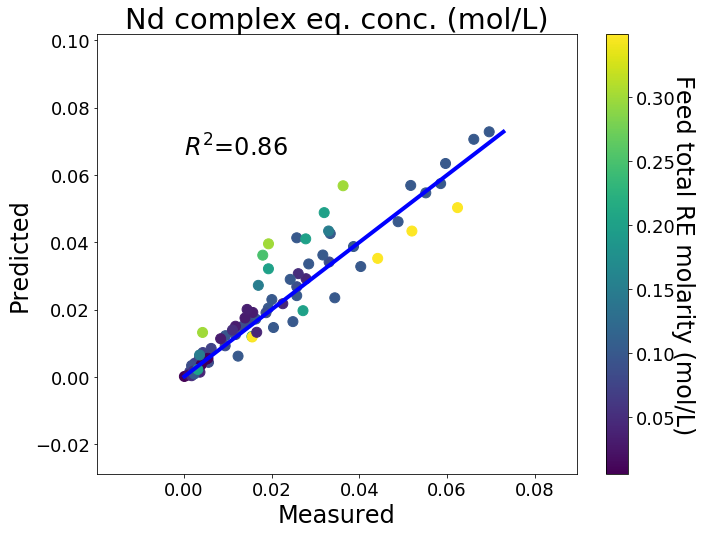

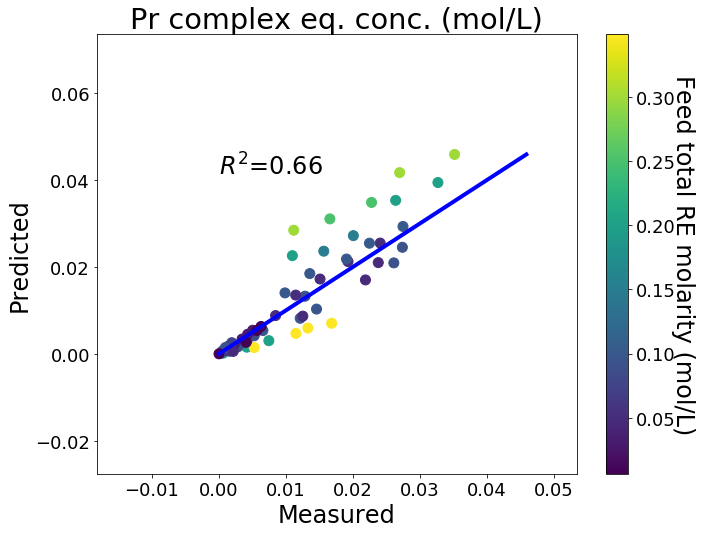

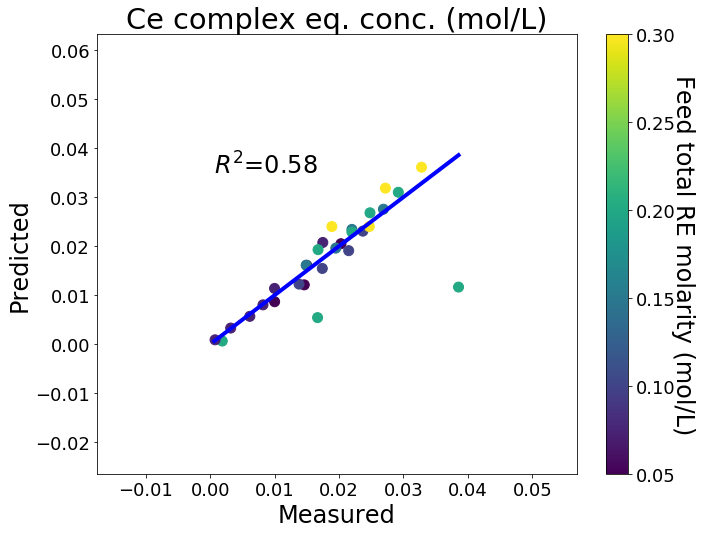

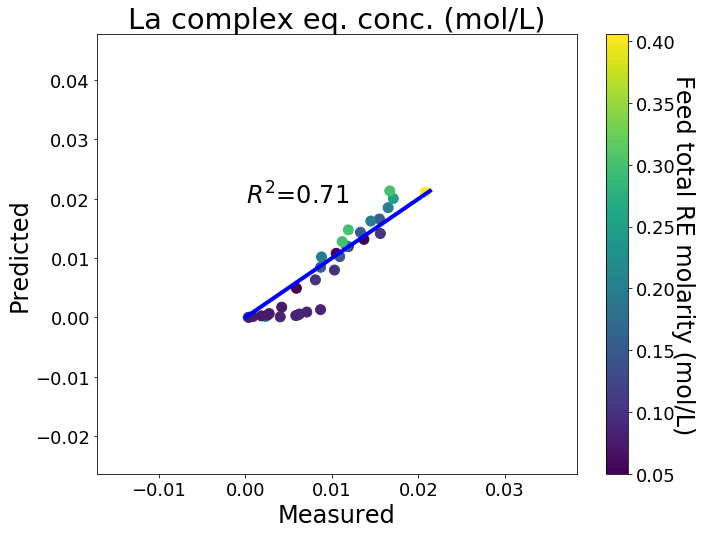

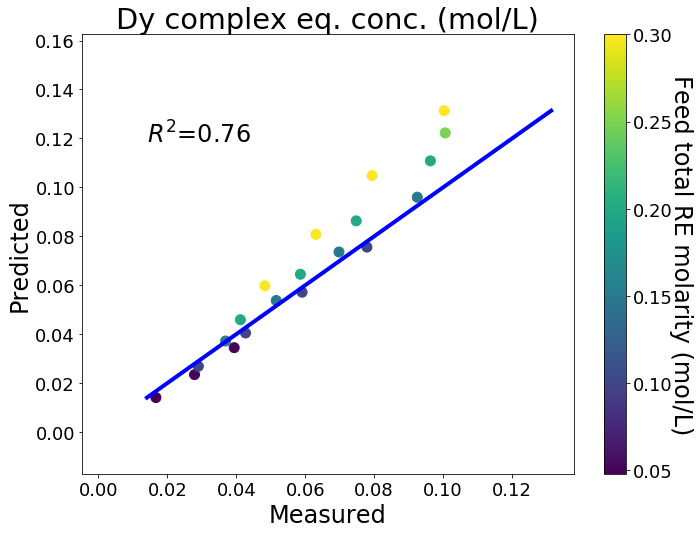

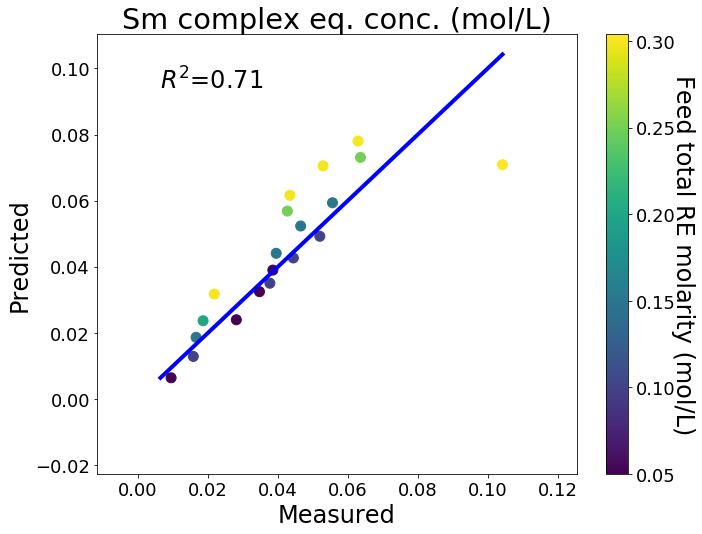

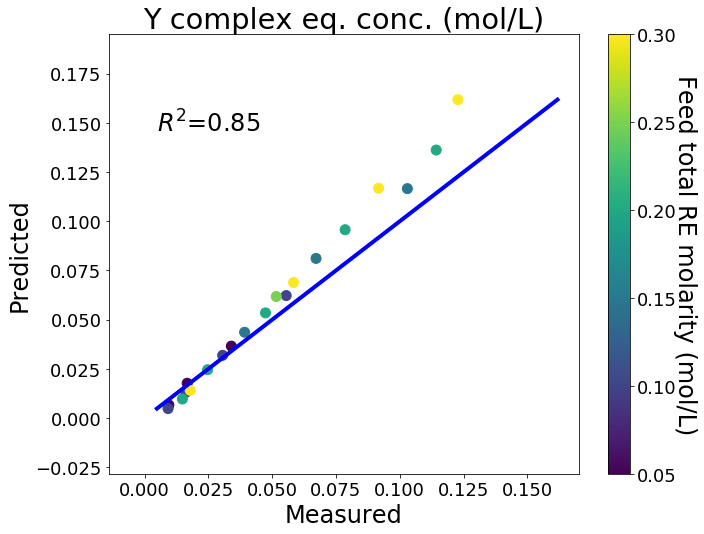

In [47]:
feed_cols = []
labeled_complete_data = pd.read_csv("../../data/csvs/PC88A_HCL_NdPrCeLaDySmY.csv")
complete_exp_df = labeled_data.drop(labeled_data.columns[0], axis=1)
estimator.set_exp_df(complete_exp_df)
exp_data = estimator.get_exp_df()
for col in exp_data.columns:
    if 'aq_i' in col:
        feed_cols.append(col)
exp_data['total_re'] = exp_data[feed_cols].sum(axis=1)
for species in species_list:
    fig, ax = estimator.parity_plot('{0}_org_eq'.format(species),
                                    c_data=
                                    exp_data['total_re'].values,
                                    c_label='Feed total RE '
                                            'molarity (mol/L)',
                                    print_r_squared=True)